<a href="https://colab.research.google.com/github/imn167/VAE_SS/blob/main/GoM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from function.VAE_GoM import *

In [60]:
!pip3 install openturns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00


In [31]:
import matplotlib.pyplot as plt
from IPython.display import clear_output #
import time
import openturns as ot

On teste le VAE sur une distribution gaussienne tronquée tel que les coordonnées des vecteurs soient supérieurs à un seuil.  

Pour des soucis d'efficacité et de faisabilité on choisit de tronquer seulement sur 2 coordonnées.

In [ ]:
#Simulation of a truncated normal distribution
def truncatedDistribution(n_samples, dim, mean, variance, lower, higher):
    sd = np.sqrt(variance)
    L = list()
    i = 0
    while i < n_samples:
        prop = np.random.normal(loc = mean, scale=sd)
        prop_norm = np.linalg.norm(prop[0:2], ord=-np.inf)

        if prop_norm > higher :
            L.append(prop)
            i += 1
            if i %10 == 0:
                clear_output(wait=True)
                print("boucle %d terminéE" %(i))

    return np.array(L)


In [ ]:
#dist = truncatedDistribution(10000, 20, np.zeros(20), np.ones(20), 2, 2)
#dist.shape

boucle 10000 terminéE


(10000, 20)

In [ ]:
#np.save('2_component_truncated.npy', dist)

In [ ]:
dist = np.load('2_component_truncated.npy')
d = dist.shape[1]

CPU times: total: 5.78 s
Wall time: 6.6 s


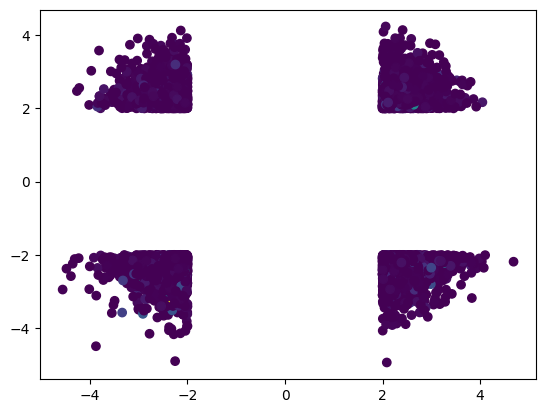

In [ ]:
%%time
kde = sp.gaussian_kde(dist.T)
plt.scatter(dist[:,0], dist[:,1], c = kde(dist.T));

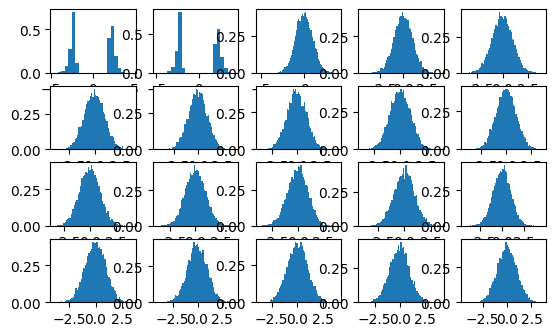

In [ ]:
for i in range(d):
    plt.subplot(5,5,i+1)
    plt.hist(dist[:, i],bins= 'auto', density=True);

In [ ]:
x = layers.Dense(6, activation='softmax')
x(tf.ones(shape=(2,1)))

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.30409288, 0.10717427, 0.16095918, 0.09249328, 0.07133057,
        0.26394975],
       [0.30409288, 0.10717427, 0.16095918, 0.09249328, 0.07133057,
        0.26394975]], dtype=float32)>

In [19]:
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import scipy.stats as sp


class MoGPrior(layers.Layer):
  def __init__(self, latent_dim, num_components, **kwargs):
    super(MoGPrior, self).__init__(**kwargs)
    self.latent_dim = latent_dim
    self.num_components = num_components

    # means and log variances (trainable parameters)
    self.means = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)),
                            trainable=True, name='means')
    self.logvars = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)),
                               trainable=True, name='logvars')

    # mixing weights (trainable parameter)
    self.w = tf.nn.softmax(tf.Variable(tf.ones(shape=(1,num_components)), trainable=True), axis = 1)

  def get_params(self):
    return self.means, self.logvars, self.w

  def call(self, batch_size):
    # get means and log variances of the mixture
    means, logvars, w = self.get_params()

    # normalize mixing weights using softmax (see gumball)
    w = tf.nn.softmax(self.w, axis=1)
    # sample component indices
    indexes = (tf.random.categorical(tf.math.log(w), batch_size))[0]

    # sample from chosen components
    z = tf.map_fn(fn= lambda indx : means[indx] + tf.random.normal(shape= (1,2)) * tf.exp(0.5*logvars[indx]),
          elems= indexes,
          dtype=tf.float32)
    z = tf.squeeze(z)

    return z
  #compute the log_density of each gaussian at the point z
  def log_normal_diag(self, z, mean, logvar):
     nn_exp = -0.5*( tf.math.log(2.0*np.pi) + logvar)
     exp = -0.5* (z-mean)**2 * (tf.exp(-logvar))
     return tf.reduce_sum(nn_exp + exp, axis = -1)

  def log_prob(self, z):
     #getting means and vars of the gausiian mixture
     means, logvars, w = self.get_params()

     #normalising the weight with the softmax transformation
     w = tf.transpose(tf.nn.softmax(w, axis=1))
     #reshape for broadcast
     z =  tf.expand_dims(z, axis=0) #1 x batch x latent_dim
     means = tf.expand_dims(means, axis=1) #num_compo x 1 x latent_dim
     logvars = tf.expand_dims(logvars, axis=1) #num_compo x 1 x latent_dim

     #we compute the log of each gaussian for each z
     log_p = self.log_normal_diag(z, means, logvars) + tf.math.log(w) #num_compo x batch
     log_p = tf.squeeze(log_p)
     prob = tf.reduce_logsumexp(log_p, axis=0) #log(sum(exp())) #batch
     return prob

In [20]:
mixture = MoGPrior(2, 16)
z = mixture(tf.constant(5))
w = tf.nn.softmax(mixture.w, axis = 1)
z = tf.expand_dims(z, axis=0)
means = mixture.means
means = tf.expand_dims(means, axis=1)
logvar = tf.expand_dims(mixture.logvars, axis=1)
nn_exp = -0.5*(tf.math.log(2.0*np.pi) + logvar)
exp_ = -0.5*(z - means)**2 * (tf.exp(-logvar))
tf.reduce_sum(exp_ + nn_exp, axis=-1)
tf.reduce_logsumexp(tf.reduce_sum(exp_ + nn_exp, axis=-1) + tf.math.log(tf.transpose(w)), axis=0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-3.251144 , -2.8414035, -3.2437236, -2.4923704, -2.5652518],
      dtype=float32)>

In [21]:
mixture.log_prob(z)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-3.251144 , -2.8414035, -3.2437236, -2.4923704, -2.5652518],
      dtype=float32)>

In [ ]:
tf.reduce_logsumexp(mixture.log_normal_diag(z, means, logvar) + tf.math.log(tf.transpose(w)), axis = 0)
mixture.log_prob(z) == mixture.log_normal_diag(z, means, logvar) + tf.math.log(tf.transpose(w))

<tf.Tensor: shape=(16, 5), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])>

In [ ]:
encoder = Encoder(d,2)
decoder = Decoder(d,2)
mixture = MoGPrior(2,16)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.005))
history = vae.fit(dist,epochs=10,
    batch_size=200,
    shuffle=True)

Epoch 1/10


c:\Python\311\Lib\site-packages\keras\src\layers\layer.py:360: UserWarning: `build()` was called on layer 'vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.3054 - loss: 13.1128 - reconstruction_loss: 12.8074
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0548 - loss: 11.8679 - reconstruction_loss: 11.8131
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0501 - loss: 11.8531 - reconstruction_loss: 11.8030 
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0502 - loss: 11.8778 - reconstruction_loss: 11.8276
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0860 - loss: 11.8589 - reconstruction_loss: 11.7729
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0686 - loss: 11.8690 - reconstruction_loss: 11.8004 
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0376 - loss: 11.8038 - reconstruction_loss: 11.7662
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0556 - loss: 11.8177 - reconstruction_loss: 11.7621
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0274 - loss: 11.8158 - rec

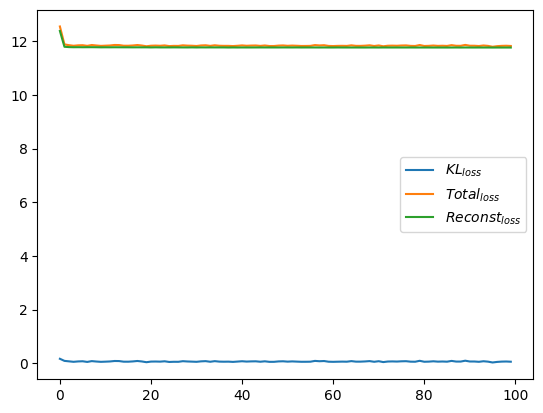

In [ ]:
plt.plot(history.history['kl_loss'], label = r'$KL_{loss}$')
plt.plot(history.history['loss'], label = r'$Total_{loss}$')
plt.plot(history.history['reconstruction_loss'], label = r'$Reconst_{loss}$')
plt.legend()

In [ ]:
vae.trainable_variables

[<KerasVariable shape=(20, 20), dtype=float32, path=vae/encoder/dense/kernel>,
 <KerasVariable shape=(20,), dtype=float32, path=vae/encoder/dense/bias>,
 <KerasVariable shape=(20, 64), dtype=float32, path=vae/encoder/dense_1/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=vae/encoder/dense_1/bias>,
 <KerasVariable shape=(64, 32), dtype=float32, path=vae/encoder/dense_2/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=vae/encoder/dense_2/bias>,
 <KerasVariable shape=(32, 2), dtype=float32, path=vae/encoder/z_mean/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/encoder/z_mean/bias>,
 <KerasVariable shape=(32, 2), dtype=float32, path=vae/encoder/z_log_var/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/encoder/z_log_var/bias>,
 <KerasVariable shape=(2, 2), dtype=float32, path=vae/decoder/dense_3/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/decoder/dense_3/bias>,
 <KerasVariable shape=(2, 32), dtype=float32, path=vae/decoder/dens

In [ ]:
class Variable_training(layers.Layer):
    def __init__(self, num_components, latent_dim, **kwargs):
        super(Variable_training, self).__init__( name = 'variables', **kwargs)
        self.n_components = num_components
        self.latent_dim = latent_dim

        self.means = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)), name = 'means', trainable=True)
        self.logvars = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)), name = 'logvars', trainable=True)
        self.w = tf.Variable(tf.random.normal(shape=(num_components, 1)), name = 'logvars', trainable=True)
    def call(self):

        return self.means, self.logvars, self.w

In [ ]:
tensorf_var = Variable_training(6,2)
tensorf_var.trainable_variables

[]

In [ ]:
vae = VAE(encoder, decoder, mixture)
vae.trainable_weights

[<KerasVariable shape=(20, 20), dtype=float32, path=vae/encoder/dense/kernel>,
 <KerasVariable shape=(20,), dtype=float32, path=vae/encoder/dense/bias>,
 <KerasVariable shape=(20, 64), dtype=float32, path=vae/encoder/dense_1/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=vae/encoder/dense_1/bias>,
 <KerasVariable shape=(64, 32), dtype=float32, path=vae/encoder/dense_2/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=vae/encoder/dense_2/bias>,
 <KerasVariable shape=(32, 2), dtype=float32, path=vae/encoder/z_mean/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/encoder/z_mean/bias>,
 <KerasVariable shape=(32, 2), dtype=float32, path=vae/encoder/z_log_var/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/encoder/z_log_var/bias>,
 <KerasVariable shape=(2, 2), dtype=float32, path=vae/decoder/dense_3/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/decoder/dense_3/bias>,
 <KerasVariable shape=(2, 32), dtype=float32, path=vae/decoder/dens

In [ ]:
mixture = vae.prior
mixture.non_trainable_weights

[]

In [ ]:
_,_, z = encoder(dist)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

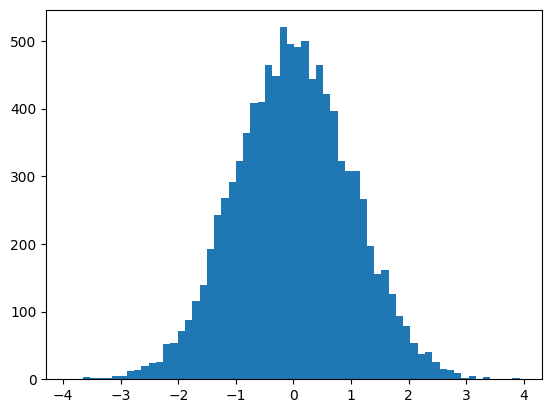

In [ ]:
plt.hist(sample[:, 5], bins='auto');

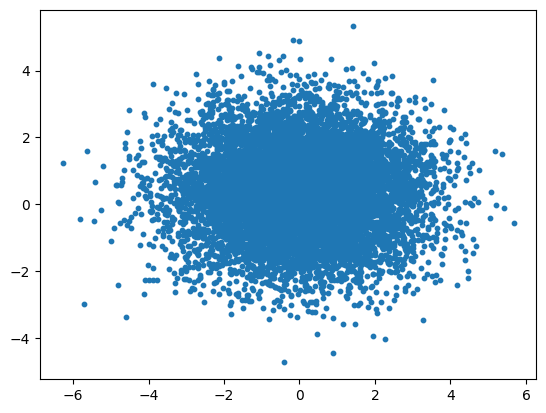

In [ ]:
plt.scatter(z[:, 0], z[:, 1], s = 10)

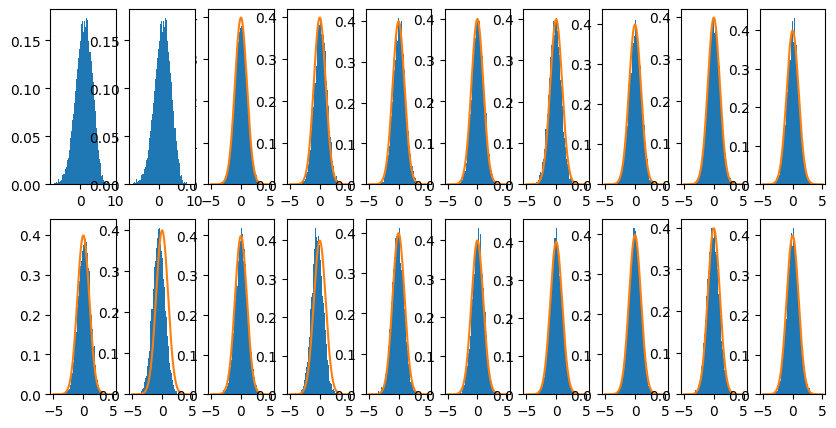

In [ ]:
plt.figure(figsize=(10,5))
col = int(d/2)
xx = np.linspace(-5,5, 1000)
distr1 = ot.TruncatedDistribution(ot.Normal(1), 2, ot.TruncatedDistribution.LOWER)
distr2 = ot.TruncatedDistribution(ot.Normal(1), 2, ot.TruncatedDistribution.LOWER)
for i in range(2,d):
    plt.subplot(2, col, i+1)
    plt.hist(sample[:,i], density=True, bins = 'auto');
    plt.plot(xx, sp.norm.pdf(xx))
plt.subplot(2, col, 1)
plt.hist(sample[:,0], density=True, bins = 'auto');
#plt.plot(xx, distr1.computePDF(xx.reshape((-1,1))))

plt.subplot(2, col, 2)
plt.hist(sample[:,0], density=True, bins = 'auto');
#plt.plot(xx, distr2.computePDF(xx.reshape((-1,1))))

In [ ]:
print(f"La moyenne empirique de la  1er composante {np.mean(mean_x, axis=0)[0]} et la moyenne théorique  {sp.norm.pdf(2)/(1-sp.norm.cdf(2))}" )
print(f"Moyenne empirique {np.mean(tf.exp(log_var_x/2), axis = 0 )[0]}, moyenne théorique {np.sqrt(1 - sp.norm.pdf(2)/(1-sp.norm.cdf(2)) * (sp.norm.pdf(2)/(1-sp.norm.cdf(2)) - 2))}")

La moyenne empirique de la  1er composante 2.3693594932556152 et la moyenne théorique  2.373215532822841
Moyenne empirique 0.3409057855606079, moyenne théorique 0.33805191970181275


In [44]:
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import scipy.stats as sp


import time

##### Creation of the Sampling class ########

class MoGPrior(layers.Layer):
  def __init__(self, latent_dim, num_components, **kwargs):
    super(MoGPrior, self).__init__(**kwargs)
    self.latent_dim = latent_dim
    self.num_components = num_components

    # means and log variances (trainable parameters)
    self.means = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)),
                            trainable=True, name='means')
    self.logvars = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)),
                               trainable=True, name='logvars')

    # mixing weights (trainable parameter)
    self.w = tf.Variable(tf.random.normal(shape=(1,num_components)), trainable=True)

  def get_params(self):
    return self.means, self.logvars, self.w

  def call(self, batch_size):
    # get means and log variances of the mixture
    means, logvars, w = self.get_params()

    # normalize mixing weights using softmax (see gumball)
    w = tf.nn.softmax(self.w, axis=1)
    # sample component indices
    indexes = (tf.random.categorical(tf.math.log(w), batch_size))[0]

    # sample from chosen components
    z = tf.map_fn(fn= lambda indx : means[indx] + tf.random.normal(shape= (1,2)) * tf.exp(0.5*logvars[indx]),
          elems= indexes,
          dtype=tf.float32)
    z = tf.squeeze(z)

    return z
  #compute the log_density of each gaussian at the point z
  def log_normal_diag(self, z, mean, logvar):
     nn_exp = -0.5*( tf.math.log(2.0*np.pi) + logvar)
     exp = -0.5* (z-mean)**2 * (tf.exp(-logvar))
     return tf.reduce_sum(nn_exp + exp, axis = -1)

  def log_prob(self, z):
     #getting means and vars of the gausiian mixture
     means, logvars, w = self.get_params()

     #normalising the weight with the softmax transformation
     w = tf.transpose(tf.nn.softmax(w, axis=1))
     #reshape for broadcast
     z =  tf.expand_dims(z, axis=0) #1 x batch x latent_dim
     means = tf.expand_dims(means, axis=1) #num_compo x 1 x latent_dim
     logvars = tf.expand_dims(logvars, axis=1) #num_compo x 1 x latent_dim

     #we compute the log of each gaussian for each z
     log_p = self.log_normal_diag(z, means, logvars) + tf.math.log(w) #num_compo x batch
     prob = tf.reduce_logsumexp(tf.squeeze(log_p), axis=0) #log(sum(exp())) #batch
     return prob


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape= (batch, dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

##### Creation of the Encoder Class #####
class Encoder(layers.Layer):
  def __init__(self, input_dim, latent_dim, **kwargs):
    super(Encoder, self).__init__(name='encoder', **kwargs)
    self.enc1 = layers.Dense(input_dim, activation='relu')
    self.enc2 = layers.Dense(64, activation = 'relu')
    self.enc3 = layers.Dense(32, activation = 'relu')
    self.mean_z = layers.Dense(latent_dim, name = 'z_mean')
    self.logvar_z = layers.Dense(latent_dim, name = 'z_log_var')
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.enc1(inputs)
    x = self.enc2(x)
    x = self.enc3(x)
    z_mean = self.mean_z(x)
    z_log_var = self.logvar_z(x)
    z = self.sampling([z_mean, z_log_var])
    return z_mean, z_log_var, z



############## Creation of the Decoder Class #################
class Decoder(layers.Layer):

 def __init__(self,input_dim, latent_dim, **kwargs):
    super(Decoder, self).__init__(name='decoder', **kwargs)
    self.dec1 = layers.Dense(latent_dim, activation='relu' )
    self.dec2 = layers.Dense(32, activation='relu')
    self.dec3 = layers.Dense(64, activation='relu')
    self.out = layers.Dense(input_dim, name = 'x_out')
    self.x_log_var = layers.Dense(input_dim, name = 'x_log_var')

 def call(self, z):
   z = self.dec1(z)
   z = self.dec2(z)
   z = self.dec3(z)
   return self.out(z), self.x_log_var(z)


##################### Creation of subclass od Model : VAE ########################
## We can see the subclass VAE as a Keras Model therefore it has the several method as fit and compile
## We overwrite the train function of the model : train_step (customizing the training)
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, prior, **kwargs):
        super(VAE, self).__init__(name = 'vae', **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

        self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name = 'kl_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name = 'reconstruction_loss')

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction, x_log_var = self.decoder(z)
        #batch = tf.shape(z_mean)[0]
        #prior_sample = self.prior(batch)
        return z_mean, z_log_var, reconstruction, x_log_var, z

    def get_encoder_decoder(self):
        return self.encoder, self.decoder

    def train_step(self, data):
       # data, y = data
        #y = tf.reshape(y,[-1])
        with tf.GradientTape() as tape :

            z_mean, z_log_var, reconstruction, x_log_var, z = self(data)
            #we compute the first loss : the log-likelyhood
            scale_x = tf.exp(x_log_var) #variance
            log_pdf = 0.5 * tf.reduce_sum(tf.pow(data-reconstruction, 2) / scale_x + x_log_var, axis = 1) #-log_pdf because we want to maximise it (SGD aim to minimize in keras)
            reconstruction_loss =  tf.reduce_mean(log_pdf) #tf.multiply(log_pdf, y)
            entropy =  tf.reduce_sum(-0.5 * (tf.math.log(2.0*np.pi) + 1 +  z_log_var), axis=1 )
            cross_entropy= self.prior.log_prob(z)
            kl_loss = tf.reduce_mean(entropy -cross_entropy)
            total_loss =( reconstruction_loss + kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}





In [19]:
dist = np.load('2_component_truncated.npy')
d = dist.shape[1]

In [57]:
#Simulation of a truncated normal distribution
def truncatedDistribution(n_samples,  mean, variance,  bound):
    sd = np.sqrt(variance)
    L = list()
    i = 0
    while i < n_samples:
        prop = np.random.normal(loc = mean, scale=sd)
        #prop_norm = np.linalg.norm(prop[0:2], ord=-np.inf)

        if (prop[0:2] > bound).all() :
            L.append(prop)
            i += 1
            if i %10 == 0:
                clear_output(wait=True)
                print("boucle %d terminée" %(i))

    return np.array(L)

In [58]:
dist = truncatedDistribution(10000, np.zeros(d), np.ones(d), 2 )

boucle 10000 terminée


In [65]:
np.save('2_component_1Side_truncated.npy', dist)

In [ ]:
encoder = Encoder(d,2)
decoder = Decoder(d,2)
mixture = MoGPrior(2,3)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001))
history = vae.fit(dist,epochs=150,
    batch_size=100,
    shuffle=True)

Epoch 1/150
100/100 [==============================] - 4s 4ms/step - loss: 11.7796 - kl_loss: 0.1679 - reconstruction_loss: 11.6117
Epoch 2/150
100/100 [==============================] - 0s 3ms/step - loss: 9.2123 - kl_loss: 0.1112 - reconstruction_loss: 9.1010
Epoch 3/150
100/100 [==============================] - 0s 3ms/step - loss: 8.0247 - kl_loss: 0.0638 - reconstruction_loss: 7.9609
Epoch 4/150
100/100 [==============================] - 0s 4ms/step - loss: 7.8562 - kl_loss: 0.0314 - reconstruction_loss: 7.8248
Epoch 5/150
100/100 [==============================] - 0s 3ms/step - loss: 7.8479 - kl_loss: 0.0305 - reconstruction_loss: 7.8174
Epoch 6/150
100/100 [==============================] - 1s 5ms/step - loss: 7.8298 - kl_loss: 0.0185 - reconstruction_loss: 7.8113
Epoch 7/150
100/100 [==============================] - 1s 5ms/step - loss: 7.8313 - kl_loss: 0.0204 - reconstruction_loss: 7.8108
Epoch 8/150
100/100 [==============================] - 1s 6ms/step - loss: 7.8370 - kl_l

In [67]:
mixture.means

<tf.Variable 'means:0' shape=(4, 2) dtype=float32, numpy=
array([[-1.2373428 , -1.7476441 ],
       [-0.66519403, -1.1926384 ],
       [-1.1993573 , -0.10625177],
       [-0.11403792, -0.8078624 ]], dtype=float32)>

In [68]:
tf.exp(mixture.logvars*0.5)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1.1544298 , 1.0446303 ],
       [1.2600725 , 0.8686454 ],
       [0.8370952 , 0.47446105],
       [1.0081733 , 0.83845437]], dtype=float32)>

In [69]:
tf.nn.softmax(mixture.w)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.2994404 , 0.49464124, 0.0428276 , 0.16309075]], dtype=float32)>

In [70]:
_,_, z = encoder(dist)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

(array([  12.,  150.,  626., 1789., 2851., 2661., 1400.,  418.,   85.,
           8.]),
 array([1.12736999, 1.38602417, 1.64467834, 1.90333252, 2.1619867 ,
        2.42064087, 2.67929505, 2.93794923, 3.1966034 , 3.45525758,
        3.71391176]),
 <BarContainer object of 10 artists>)

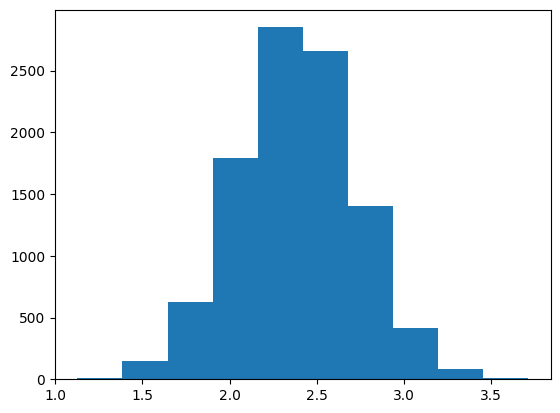

In [74]:
plt.hist(sample[:, 1])

On obtient les mêmes valeurs si on init pas avec des poids random

In [53]:
encoder = Encoder(d,2)
decoder = Decoder(d,2)
mixture = MoGPrior(2,6)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001))
history = vae.fit(dist,epochs=100,
    batch_size=150,
    shuffle=True)

Epoch 1/100
67/67 [==============================] - 3s 4ms/step - loss: 13.3992 - kl_loss: 0.3005 - reconstruction_loss: 13.0987
Epoch 2/100
67/67 [==============================] - 0s 3ms/step - loss: 12.1960 - kl_loss: 0.1786 - reconstruction_loss: 12.0174
Epoch 3/100
67/67 [==============================] - 0s 3ms/step - loss: 12.0045 - kl_loss: 0.1280 - reconstruction_loss: 11.8765
Epoch 4/100
67/67 [==============================] - 0s 3ms/step - loss: 11.9251 - kl_loss: 0.1139 - reconstruction_loss: 11.8112
Epoch 5/100
67/67 [==============================] - 0s 3ms/step - loss: 11.8877 - kl_loss: 0.1087 - reconstruction_loss: 11.7790
Epoch 6/100
67/67 [==============================] - 0s 3ms/step - loss: 11.8475 - kl_loss: 0.0799 - reconstruction_loss: 11.7676
Epoch 7/100
67/67 [==============================] - 0s 4ms/step - loss: 11.8172 - kl_loss: 0.0533 - reconstruction_loss: 11.7639
Epoch 8/100
67/67 [==============================] - 0s 4ms/step - loss: 11.8152 - kl_loss

In [56]:
tf.nn.softmax(mixture.w)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.09071483, 0.16884713, 0.2675017 , 0.24746065, 0.13845877,
        0.08701682]], dtype=float32)>

In [64]:
ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
samples =myMixture.getSample(1000)

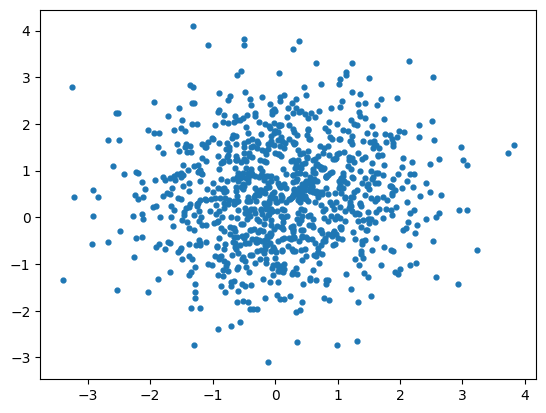

In [66]:
plt.scatter(samples[:,0], samples[:,1], s=12)
plt.scatter(z)

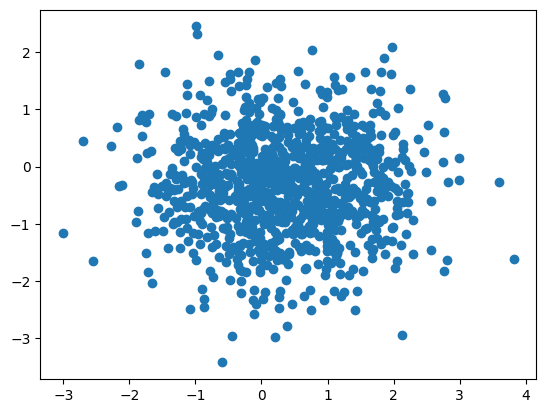

In [79]:
sample = mixture(1000)
plt.scatter(sample[:, 0], sample[:, 1])
plt.scatter(dist[])